In [22]:
# Time Independent Schrodinger Equation
# Computational Physics Project 2

import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy.optimize import brentq,brenth,newton,bisect
import matplotlib.pyplot as plt

In [59]:
L = 3 # length
nx = 100 # number of grid points

x = np.linspace(0,L,nx) # grid
psi0 = 0; u0 = 1; # define initial conditions
init = np.array([psi0,u0]) #
E = 1 # Total energy

# potential function
def V(x):
    if x==0:
        return 1000
    else:
        return x
    
# psi update function
def f(psi,u,x,E):
    return u

# u update function
def g(psi,u,x,E):
    return 2*(V(x)-E)*psi

In [60]:
# return derivatives for odeint
def deriv(sol,x,E):
    psi,u = sol
    
    dpsi = f(psi,u,x,E)
    du = g(psi,u,x,E)
    
    return np.array([dpsi,du])

# solves ode for given E
def odeSolve(init,x,E):
    sol = odeint(deriv,init,x,args=(E,))
    
    return sol

sol = odeSolve(init,x,E)
psi = sol[:,0]; u = sol[:,1]

In [71]:
# solves ode for given E and returns value "at L"
def at_L(E,init,x):
    sol = odeint(deriv,init,x,args=(E,))
    
    return sol[-1,0]

EMax = 20; nE = 300; # maximum and number of values to calculate for energy
energies = np.linspace(0,EMax,nE) # array of energies
psiE = np.zeros(nE) # initialize array

for i in range(nE):
    psiE[i] = at_L(energies[i],init,x)
    

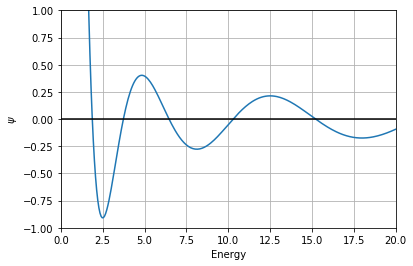

In [72]:
# Plot solution at L as function of E

plt.plot(energies,psiE)
plt.xlabel("Energy"); plt.ylabel(r"$\psi$")
plt.xlim([0,EMax]); plt.ylim([-1,1]);

plt.axhline(0, color='k')
plt.grid(True); plt.show();

In [79]:
# Root finding

x0=2.0; a=0.1; b=3.0;

#root = newton(at_L,x0,args=(init,x))
#root = bisect(at_L,a,b,args=(init,x))
#root = brenth(at_L,a,b,args=(init,x))
root = brentq(at_L,a,b,args=(init,x))

print(root)

1.8797730040941134


[  1.879773     3.7373863    6.46603724  10.29231011  15.22063323]


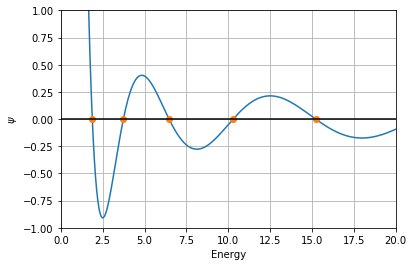

In [85]:
incr = 0.1 

a = 0.1; b = 0.2;
roots = np.empty(0)

while b < EMax:
    if (np.sign(at_L(a,init,x)) != np.sign(at_L(b,init,x))):
        root = brentq(at_L,a,b,args=(init,x))
        roots = np.append(roots,root)
        a = b; b += incr
    else:
        b += incr

print(roots)

plt.plot(energies,psiE)
plt.plot(roots,np.zeros(roots.size), 'o')
plt.xlabel("Energy"); plt.ylabel(r"$\psi$")
plt.xlim([0,EMax]); plt.ylim([-1,1]);

plt.axhline(0, color='k')
plt.grid(True); plt.show();